## Table of Contents
* [Data](#directories)
* [Introduction](#introduction)
* [Methods](#methods)
   * [Preprocessing](#preprocessing)
   * [Extracting shared expressions](#extracting-shared-expressions)
   * [Linking shared expressions](#linking-shared-expressions)
   * [Terminology & examples](#some-terminology)
* [Research questions and results](#results)
   * [1. Shared expressions and iconic gestures](#overlap_with_gestures) 
   * [2. Similarity between shared expressions and the pre & post-interaction names](#similarity_with_shared_exps)
      * [2.1. Similarity of shared expressions per speaker in each round with the pre&post interaction names](#similarity_with_pre_post_names_per_speaker)
      * [2.2. The robustness of shared expressions in conceptualizing fribbles: correlating reuse frequency with similarity to pre&post-interaction names](#similarity_with_pre_post_names_given_reuse)
   * [3. Similarity of utterances and pre & post interaction names](#similarity_with_utterances)
   * [4. Number of shared expression types per fribble](#number_shared_exps)
   * [5. Analyzing the effect of interaction on post names similarity](#correlation_with_pre_post_names)
      * [5.1. Studying the relationship between similarity scores and shared expression features during interaction](#correlation_with_shared_expression_features)
      <!-- * [4.1. Improved similarity to take into account the common ground](#improved_distance) -->
   * [6. When does cross-speaker alignment occur?](#alignment_time)
      * [6.1. At what round is cross-speaker alignment established?](#round_established)
      * [6.2. How long does it take to establish a shared expression after it has been used for the first time by the initiating speaker?](#rounds_to_establish)
   * [7. How often do speakers align](#frequency_alignment)
      * [7.1. For what percentage of fribbles is there at least one shared expression?](#percentage_shared)
      * [7.2. What percentage of fribbles does each pair align on across dialogue rounds?](#percentage_aligned)  
   * [8. How do speakers re-use shared expressions?](#reuse)
      * [8.1. Once established, on average, in how many rounds pairs re-used the expressions in subsequent rounds?](#rounds_reuse)
      * [8.2. Once established, how often are shared expressions reused or not used in subsequent rounds? (which percentage of subsequent rounds are they reused in?)](#reuse_vs_not_reuse)
      * [8.3. Dumbleplot to illustrate how interlocutors reuse shared expressions: establishment -- last rounds of reuse](#reuse_estab_last_dumbleplot)
      * [8.4. Dumbleplot to illustrate how interlocutors reuse shared expressions: first round --> establishment round](#reuse_first_estab_dumbleplot)

### Import libraries & methods <a class="anchor" id="importing_libraries"></a>

In [1]:
# code to import python libraries and set up the notebook
import seaborn as sns
import pandas as pd
import numpy as np
import colorcet as cc
from utils.initial_analysis import plot_establishing_rounds
from utils.read_labeled_and_pos_target_data import assert_match_betwee_shared_exp_and_actual_utterances, prepare_dialogue_shared_expressions_and_turns_info, extract_all_shared_exp_info, all_func_words
from utils.link_target_expressions import link_shared_expressions_final_algo, link_identical_shared_expressions_based_on_pair, link_shared_expressions_fribble_based
from utils.get_gestures_info import get_gestures_info
from utils.data_containers_forced_alignment import Turn, Gesture, Utterance
from utils.compute_shared_exp_time_windows import get_from_to_ts
from utils.read_stop_function_words import read_stop_function_words
from collections import defaultdict


pd.set_option("display.precision", 2)
palette = sns.color_palette(cc.glasbey_hv, n_colors=25)
sns.set_theme(style="whitegrid", palette=palette) 

%matplotlib inline
%load_ext autoreload
%autoreload 2

/home/eghaleb/anaconda3/envs/nlu/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/eghaleb/anaconda3/envs/nlu/lib/python3.9/site-packages/torch/cuda/__init__.py:628: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/eghaleb/anaconda3/envs/nlu/lib/python3.9/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/home/eghaleb/anaconda3/envs/nlu/lib/python3.9/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/home/eghaleb/anacon

In [2]:
# code to set up the paths
dialign_output = '../dialign/output_targets_riws_lemma_lg/'
turn_info_path = '../dialign/targets_riws_lemma_lg/'
fribbles_path = "../data/CABB/objects_fribbles/{}.jpg"
videos_path = '/Users/esamghaleb/Documents/ResearchData/CABB Small Dataset/processed_audio_video/{}/{}_synced_overview.mp4'

pos_func_words = ['DET', 'PRON', 'ADP', 'CCONJ', 'SCONJ', 'AUX', 'PART', 'PUNCT', 'SYM', 'X', 'INTJ', 'NUM', 'SPACE']
frequent_words, function_words = read_stop_function_words()

# Introduction <a class="anchor" id="introduction"></a>

This report includes the data processing methods used to operationalise lexical alignment and the results obtained so far. Lexical alignment is detected based on a lemmatized speech at the level of the lemmas' form. In a dialogue, single lemmas or sequences of lemmas used at least once by **both** participants are defined as shared expressions, and hence lexical alignment is detected. 

# Methods<a class="anchor" id="methods"></a>

## Pre-processing<a class="anchor" id="preprocessing"></a>

First, we read the dialogue data, including turns’ utterances and their corresponding information (e.g., speaker, time, co-speech gestures, etc.). Second, we pre-process speech utterances as follows:

- **Word-level time alignment:** Phoneme sequences are aligned with the corresponding transcriptions. This is done using WAV2VEC, a speech recognition model, to extract phonemes’ representations of audio raw wav frames and Connectionist Temporal Classification (CTC). For this purpose, we use the [wav2vec2-large-xlsr-53-dutch](https://huggingface.co/jonatasgrosman/wav2vec2-large-xlsr-53-dutch). Next, we utilize CTC to align the phonemes’ representations with the corresponding words, as proposed by [Graves et al., 2006](https://link.springer.com/book/10.1007/978-3-642-24797-2) and improved by [Kürzinger et al., 2020](https://arxiv.org/pdf/2007.09127.pdf). We utilized the implementation of the CTC-segmentation algorithm provided by [PyTorch tutorial on forced alignment](https://pytorch.org/tutorials/intermediate/forced_alignment_with_torchaudio_tutorial.html). The resulting alignment is of high quality, which can be useful for studying co-speech gestures and other linguistic and co-speech phenomena. [N.B.: ***This information is not exploited in the analyses summarised in this report***]

- **Removal of **dysfluencies**:** We remove tokens between and with special characters, e.g., #, *, -, etc. This removes non-verbal vocal sounds, self-repairs, and filled pauses. For example:
   
  - We remove self repairs, e.g., “ku-” in “aan de zijkant twee ku- kubussen”.

  - Non-verbal vocal sounds are removed, e.g., #laughs#, #sigh#, #click on the computer#, #tongue click#, etc.

  - We remove inaudible speech, e.g., “(?)” in “deze heeft een soort van (?) aan de zijkant”. However, if annotators transcribed the inaudible speech, we keep it, e.g., the utterance “aan de (zijkant),” is converted to “aan de zijkant”.
      
  - We remove filled pauses: e.g., "uh", "hmm", etc. For this, we use the list of interactional words accompanying the CABB dataset.
   
- **Part of speech (POS) tagging and lemmatisation:** We perform POS tagging per word (e.g., NOUN, VERB, etc.), and words are lemmatised into the base forms, e.g.: 
            
      heeft → hebben      
      Diamantjes → diamant




## Extracting shared expressions<a class="anchor" id="extracting-shared-expressions"></a>

For each dialogue (i.e., each participant pair) and each given fribble, we do the following: 

* We combine all sections of the dialogue (across rounds) where participants are trying to identify the given fribble.

* We extract all the sequences of lemmas that both dialogue participants have used across these sections of the dialogue (including sequences of length 1, i.e., single lemmas). For this step, we use the sequential pattern-matching algorithm proposed by [Duplessis et al](https://link.springer.com/article/10.1007/s10579-021-09532-w). We refer to these sequences of lemmas as **shared expressions**.

* We filter out shared expressions consisting exclusively of function words and other highly frequent words (e.g., `ja dat zijn'): 

   - Function words: To identify function words, we rely on POS tagging and exclude shared expressions that exclusively consist of them. The Universal POS tagset serves as the basis for our list of POS tags, which includes ['DET', 'PRON', 'ADP', 'CCONJ', 'SCONJ', 'AUX', 'PART', 'PUNCT', 'SYM', 'X', 'INTJ']. However, our approach can miss sequences containing only function words due to inaccurate POS tagging. To address this issue, we also refer to the function word list provided by the CABB dataset as a supplementary step in identifying and removing shared expressions with only function words.

   - Highly frequent words: following [Marlou et al.](https://www.tandfonline.com/doi/full/10.1080/0163853X.2021.1992235), highly frequent words were determined using the word frequencies in the SUBTLEX-NL corpus by [Keuleers et al.](https://link.springer.com/article/10.3758/BRM.42.3.643). We used three standard deviations above the mean as a threshold for highly frequent words.

<!-- > **QUESTION** is the CABB list of function words the only thing used, or an additional filter? --> 
<!-- **Answer** the CABB list is used as a backup if the POS tagging fails to identify sequences with only function words. --> 

We restrict our attention to shared expressions that are used for one single fribble within the entire dialogue, thus leaving aside shared expressions used for multiple fribbles in the current analyses (we may want to look into those in the future). Our rationale is the following: If an expression is repeated by both participants for several fribbles, it is likely to be a frequent expression (with a high probability of being reused) that our previous filters were not able to discard. This results in a set of ***unique shared expressions per fribble***, i.e., the sequences of contenful lemmas used by both participants for each fribble exclusively.[^1] 

> [^1] Note that under this approach, if the two participants use the same expression for two different fribbles (e.g., participant A uses *kogel* for fribble 1 but not for fribble 2, and vice versa for participant B), then this expression is not considered a shared expression. 


In [3]:
# code to read the data
shared_constructions_info, turns_info = prepare_dialogue_shared_expressions_and_turns_info(dialign_output, turn_info_path)
exp_info = extract_all_shared_exp_info(shared_constructions_info, turns_info)
pos_func_words = ['DET', 'PRON', 'ADP', 'CCONJ', 'SCONJ', 'AUX', 'PART', 'PUNCT', 'SYM', 'X', 'INTJ', 'SPACE', 'NUM']
stop_words, function_words = read_stop_function_words()
exp_with_only_func_words = np.logical_not([all_func_words(pos_seq, pos_func_words) for idx, pos_seq in enumerate(exp_info['pos_seq'].to_list())])
exp_info = exp_info[exp_with_only_func_words]
exp_with_only_func_words = np.logical_not([all_func_words(exp, function_words) for idx, exp in enumerate(exp_info['exp'].to_list())])
exp_info = exp_info[exp_with_only_func_words]
exp_with_only_stop_words = np.logical_not([all_func_words(exp, stop_words) for idx, exp in enumerate(exp_info['exp'].to_list())])
exp_info = exp_info[exp_with_only_stop_words]
exp_info['shared expressions'] = exp_info['exp'].apply(lambda x: [x])
exp_info = link_identical_shared_expressions_based_on_pair(turns_info, exp_info)
# check if there are nan values in exp_info
assert not exp_info.isnull().values.any()
exp_info = exp_info[exp_info['#fribbles'] == 1]
# Here, we assert that all detected shared expressions are in the original lemmatized utterances, with matching turn numbers
assert_match_betwee_shared_exp_and_actual_utterances(turns_info, shared_constructions_info)

### Some terminology <a class="anchor" id="some-terminology"></a>

* **Initiation turn/round:** The turn or round where a shared expression was first introduced by one of the participants.
* **Establishing turn/round:** The turn or round where the shared expression was first repeated by the other participant, i.e., it becomes shared.
* **Speaker role** is a list to indicate whether the shared expression was used by the director or the matcher. **D** & **M** refer to the director and matcher, respectively.
* **Initiator role:** The participant who introduced the shared expression, i.e., the director or the matcher.
* **Establisher role:** The participant who established the shared expression, i.e., the director or the matcher.
* **Turns** and **rounds** indicate the values (which are ordered sequences) of turns and rounds where shared expressions are used. 
* **Length** indicates the number of lemmas in the shared expression.
* **Target fribble** indicates the fribble for which the shared expression was used.
* **Frequency** indicates the number of times the shared expression was used.


### Linking shared expressions with a common lexical core <a class="anchor" id="linking-shared-expressions"></a>

The methods described above may result in sets of unique shared expressions per fribble that contain highly overlapping expressions. For example, for fribble 14, pair 10 uses the shared expressions "de bal bovenop" and "de bal," which overlap significantly. To identify such overlaps, we use regular expressions and link the expressions based on the overlap of content lemmas. We do not link the expressions if the overlapping sequence contains only function words.

This process produces sets of shared expressions that reflect a common underlying conceptualization or lexical core, which we consider instances of lexical alignment. To simplify the labeling of these sets, we assign a common lexical core as the label, which is the shortest common sequence for the set. For instance, Pair 5 has three sets of shared expressions, each labeled with a common lexical core, such as "paddestoel," which includes three shared expressions: "een paddestoel," "een paddestoel op zijn hoofd," and "paddestoel op zijn hoofd."

To illustrate the linking process of shared expressions, consider the example below for Pair 5 and Fribble 1.
<!-- > **PLOT** include plot for Pair 5 example after linking; for each occurance include which speaker (A,B) utters it. -->

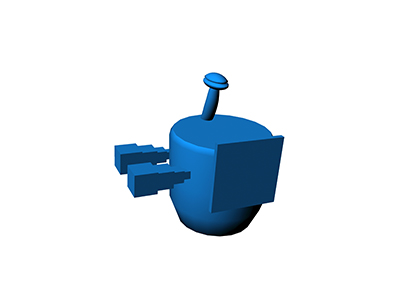

lexical core  \
0  deze hebben een paddestoel op zijn hoofd   
1                  paddestoel op zijn hoofd   
2                     twee vierkant schroef   
3                                een scherm   
4                                paddestoel   

                           shared expressions freq         speakers  \
0  [deze hebben een paddestoel op zijn hoofd]    2           [B, A]   
1                  [paddestoel op zijn hoofd]    4     [A, B, A, A]   
2                     [twee vierkant schroef]    3        [B, A, B]   
3                                [een scherm]    2           [B, A]   
4                                [paddestoel]    5  [A, B, A, B, A]   

      speaker role initiator role establisher role           rounds  
0           [D, D]            [D]              [D]           [3, 4]  
1     [D, D, D, D]            [D]              [D]     [2, 3, 4, 6]  
2        [D, D, M]            [D]              [D]        [1, 4, 6]  
3           [D, D]            [D]              [D]           [3, 4]  
4  [D, D, D, D, D]            [D]              [D]  [2, 3, 4, 5, 6]

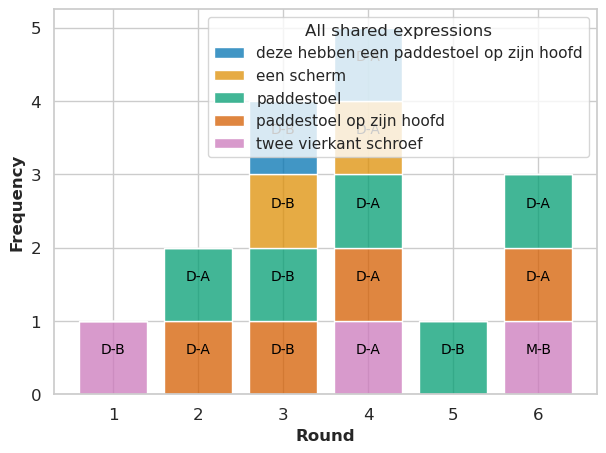

#################################### shared expressions after linking ####################################


lexical core  \
0             paddestoel   
1  twee vierkant schroef   
2             een scherm   

                                                                 shared expressions  \
0  [paddestoel op zijn hoofd, paddestoel, deze hebben een paddestoel op zijn hoofd]   
1                                                           [twee vierkant schroef]   
2                                                                      [een scherm]   

  freq         speakers     speaker role initiator role establisher role  \
0    5  [A, B, A, B, A]  [D, D, D, D, D]            [D]              [D]   
1    3        [B, A, B]        [D, D, M]            [D]              [D]   
2    2           [B, A]           [D, D]            [D]              [D]   

            rounds  
0  [2, 3, 4, 5, 6]  
1        [1, 4, 6]  
2           [3, 4]

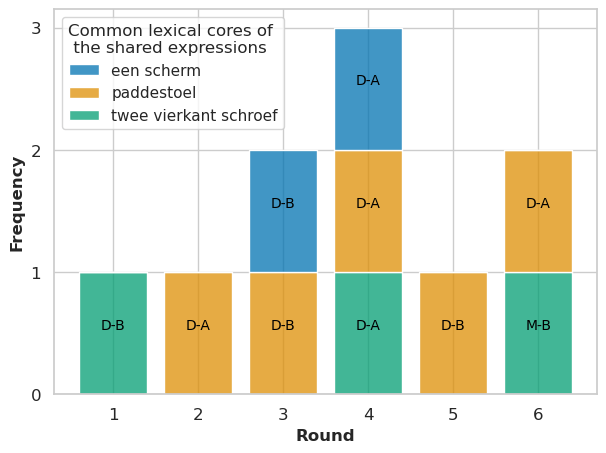

In [4]:
# method to illustrate the linking process
num_fribbles = 1
target_fribble = '01'
target_pair = 'pair05'
pair = target_pair
linked_expressions = link_shared_expressions_fribble_based(turns_info, exp_info, function_words, pos_func_words, num_fribbles=num_fribbles, target_fribble=target_fribble, target_pair=target_pair, fribbles_path=fribbles_path, videos_path=videos_path, save_clips=False)

In [5]:
# code to get the final set of shared expressions
# select exps where #fribbles is only 1
assert_match_betwee_shared_exp_and_actual_utterances(turns_info, shared_constructions_info)
pairs_without_audio_recordings = ['011012', '097098', '137138', '127128', '153154', 'pair19'] # these pairs have no audio recordings
# get word-level time windows for each lemma in each shared expression
exp_info['to_ts'] = exp_info.apply(lambda row: get_from_to_ts(row, turns_info, 'to_ts', pairs_without_audio_recordings), axis=1) # type: ignore
exp_info['from_ts'] = exp_info.apply(lambda row: get_from_to_ts(row, turns_info, 'from_ts', pairs_without_audio_recordings), axis=1) # type: ignore
# Here, we assert that all detected shared expressions are in the original lemmatized utterances, with matching turn numbers
linked_exp_info = link_shared_expressions_final_algo(turns_info, exp_info, function_words, pos_func_words)
# rename exp to label
linked_exp_info = linked_exp_info.rename(columns={'exp': 'label'})
linked_exp_info['#shared expressions'] = linked_exp_info['shared expressions'].apply(lambda x: len(x))
for row_idx, row in linked_exp_info.iterrows():
   pair = row['pair']
   turns = row['turns']
   for turn in turns:
      assert row['label'] in turns_info[pair][int(turn)].lemmas_sequence
      
fribble_specific_exp_info = linked_exp_info[linked_exp_info['#fribbles'] == 1]
fribble_specific_exp_info['target_fribble'] = fribble_specific_exp_info.apply(lambda row: row['target_fribbles'][0], axis=1) # type: ignore

# Results <a class="anchor" id="results"></a> 
<!-- For how many fribbles do participant pairs align lexically? 
N pairs use at least one shared expression for all 16 fribbles; M pairs align on X fribbles, ....


When are shared expressions initiated and established?
Most shared expressions are established in the following round of having been introduced

How often are shared expressions reused? Once established, in how many are (out of the remaining rounds) are they reused? We exclude expressions established in round 6. 
- dumble plot: initiation round, frequency of reuse in each round

Features that could correlate with pre-post names and conceptualisations: 
- frequency of use of the shared expression, e.g., regarding number of rounds (or ration of remaining rounds)
- presence of a co-speech gesture?
 -->
 
This section presents the initial analysis of the shared expressions. For this analysis, we use shared expressions used by interlocuters for a single fribble. We use both the small and the large CABB datasets. The small dataset contains 20 pairs, and the large dataset contains 47 pairs. In the large dataset, we use dialogues of the referential task and exclude the conversations of the localization task. The analysis studies the research questions outlined in TOC and the results are presented in the following sections.

### 1. Shared expressions and iconic gestures <a class="anchor" id="overlap_with_gestures"></a>

We explore the overlap between shared expressions and iconic gestures. We ask: do share expressions overlap with iconic gestures more than other types of speech?

To answer this question, we create a baseline of non-shared expressions, carefully considering the following factors:

   * Firstly, we ensure that the length distribution of the non-shared expressions is the same as that of the shared expressions. To achieve this, we use the geometric distribution to model the length of the expressions, which is the best fit for the distribution of shared expressions. Then, we sample the same number of non-shared expressions as shared expressions from the geometric distribution.
   
   * Secondly, like shared expressions, we make sure the baseline non-shared expressions also contain content words. 
   
   * Lastly, we select both shared and non-shared expressions from rounds where iconic gestures were annotated (at the time of writing, this annotation is only available for specific pairs and rounds).

The first few plots below show that the non-shared expression are indeed very similar in length and duration to shared expressions, with the former having slightly longer duration. They are therefore an appropriate baseline. 

**Main finding:** as shown in the last figure below, shared expressions have a significantly higher overlap with iconic gestures compared to the baseline non-shared expressions. This indicates that shared expressions are more likely to be accompanied by iconic gestures than other types of speech.

> Raquel: This could suggest that if an expression is accompanied by an iconic gesture, it is more likely to become shared? To test this, we could check the frequency of gesture overlap in the initiating turn vs. the establishing turn vs. other turns. But I guess we don't have enough gesture annotations for this. 


In [9]:
def get_interactional_words():
    interaction_words = []
    interaction_words_path = '../data/words_lists/interaction_words.txt'
    with open(interaction_words_path) as f:
        lines = f.readlines()
    for word in lines:
        word = word.split("\n")[0]
        interaction_words.append(word)
    return interaction_words
interaction_words = get_interactional_words()

In [10]:
# code to establish a strong baseline for non-shared expressions
# first select pairs_with_annotatations
shared_constructions_info, turns_info = prepare_dialogue_shared_expressions_and_turns_info(dialign_output, turn_info_path)
exp_info_for_gestures = extract_all_shared_exp_info(shared_constructions_info, turns_info)
exp_info_for_gestures = exp_info_for_gestures[exp_info_for_gestures['dataset'] == 'small']
 
# remove exp_info_for_gestures that for pair 19
exp_info_for_gestures = exp_info_for_gestures[exp_info_for_gestures['pair'] != 'pair19']


In [11]:

gestures_info, gesture_data = get_gestures_info(turns_info)
time_based_exp_info = exp_info_for_gestures.explode(['rounds', 'turns', 'fribbles', 'speakers'])
# merge duplicated gestures with different hands (e.g. L and R) but same gesture
# fill nan values in gestures_info with empty strings
gestures_info = gestures_info.fillna('')
# group gestures by pair, turn, type, is_gesture, from_ts, to_ts, referent, comment, and duration
gestures_info = gestures_info.groupby(['pair', 'turn', 'round', 'type', 'is_gesture', 'from_ts', 'to_ts', 'referent', 'comment', 'duration']).agg({'hand': lambda x: list(x)}).reset_index()

gesture_data = gestures_info.groupby('type').count().reset_index().rename(columns={'pair': 'count'})[['type', 'count']]
gesture_data['normalized_count'] = gesture_data['count'] / gesture_data['count'].sum()
# gesture_data['normalized_count'] = gesture_data['normalized_count'].apply(lambda x: round(x, 2))

In [13]:
gestures_info[gestures_info['type'] == 'iconic']

pair  turn round    type is_gesture  from_ts    to_ts referent  \
1     pair04     0     1  iconic    gesture     4.09     4.50     main   
5     pair04     2     1  iconic    gesture     8.46     8.94      09C   
8     pair04     4     1  iconic    gesture    11.78    12.20      09C   
9     pair04     4     1  iconic    gesture    11.97    12.39   15A-WF   
10    pair04     4     1  iconic    gesture    12.29    12.73      09C   
...      ...   ...   ...     ...        ...      ...      ...      ...   
6992  pair24   458     4  iconic    gesture  1300.69  1301.63      16C   
6993  pair24   459     4  iconic    gesture  1300.69  1301.63      16C   
6994  pair24   470     4  iconic    gesture  1321.06  1321.42  general   
6995  pair24   470     4  iconic    gesture  1322.46  1322.70      12B   
6996  pair24   470     4  iconic    gesture  1323.18  1324.02      12C   

                 comment  duration    hand  
1                             0.41  [R, L]  
5                             0.48     [L]  
8                             0.42     [L]  
9     superimposed beats      0.42     [L]  
10      Post-stroke hold      0.44     [L]  
...                  ...       ...     ...  
6992                          0.95  [R, L]  
6993                          0.95  [R, L]  
6994                          0.36     [L]  
6995                          0.24  [R, L]  
6996                          0.84     [L]  

[5671 rows x 11 columns]

In [14]:
gestures_info.groupby(['type']).count().reset_index().rename(columns={'pair': 'count'})[['type', 'count']]

type  count
0               752
1    deictic    164
2     iconic   5671
3      other    402
4  undecided      8

<AxesSubplot: xlabel='type', ylabel='count'>

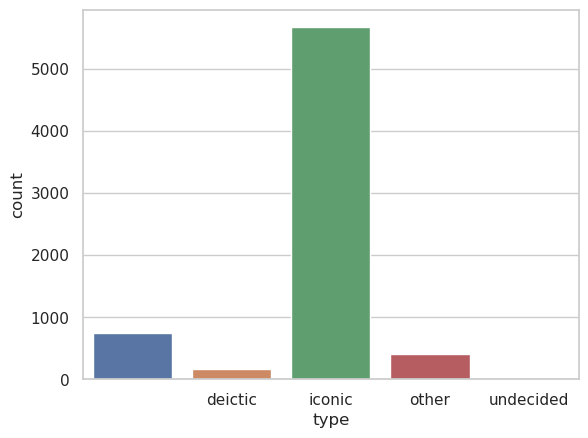

In [15]:
# provide bar plot of gesture types where the x axis is the round, hue is the type, and y axis is the count, using seaborn
# provide bar plot of gesture types where the x axis is the round, hue is the type, and y axis is the normalized count, using seaborn
import seaborn as sns
sns.set_theme(style="whitegrid")
# first group the gestures by round and type
grouped_gestures = gestures_info.groupby(['round', 'type']).count().reset_index().rename(columns={'pair': 'count'})[['round', 'type', 'count']]
# fill ' ' values in gestures_info with undecided strings
grouped_gestures = grouped_gestures.fillna('non-gesture')
sns.barplot(x='type', y='count', data=gestures_info.groupby(['type']).count().reset_index().rename(columns={'pair': 'count'})[['type', 'count']])

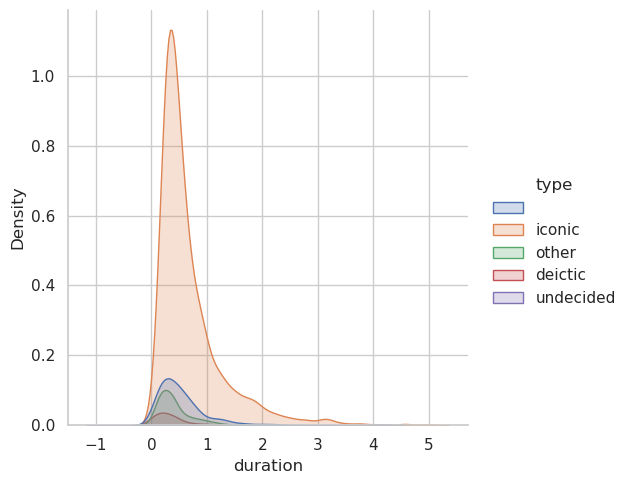

In [16]:
# plot the distribution of gestures' durations
sns.displot(gestures_info, x='duration', hue='type', kind='kde', fill=True)

In [18]:
gestures_info['WF'] = gestures_info['referent'].apply(lambda x: 'WF' in x)
gestures_info['target_fribble'] = gestures_info.apply(lambda row: turns_info[row['pair']][int(row['turn'])].target, axis=1)
gestures_info['role'] = gestures_info.apply(lambda row: turns_info[row['pair']][int(row['turn'])].director, axis=1)
gestures_info['speaker'] = gestures_info.apply(lambda row: turns_info[row['pair']][int(row['turn'])].speaker, axis=1)
gestures_info['processed_referent'] = gestures_info['referent'].apply(lambda x: x.split('-')[0].split('+'))
gestures_info['pair_speaker'] = gestures_info['pair'] +'_'+ gestures_info['speaker']

process_gestures_info = gestures_info.explode('processed_referent')
iconic_gestures_info = process_gestures_info[process_gestures_info['type'] == 'iconic']
# replace 'main' with 'target' in processed_referent column
iconic_gestures_info['processed_referent'] = iconic_gestures_info.apply(lambda row: row['target_fribble'] + '_main' if row['processed_referent'] == 'main' else row['processed_referent'], axis=1)
# replace 'general' with 'target' in processed_referent column
iconic_gestures_info['processed_referent'] = iconic_gestures_info.apply(lambda row: row['target_fribble']+'_general' if row['processed_referent'] == 'general' else row['processed_referent'], axis=1)
# remove rows where process_referent is empty
iconic_gestures_info = iconic_gestures_info[iconic_gestures_info['processed_referent'] != '']
# remove rows where process_referent is 'undecided' or ' '
iconic_gestures_info = iconic_gestures_info[iconic_gestures_info['processed_referent'] != 'undecided']
iconic_gestures_info = iconic_gestures_info[iconic_gestures_info['processed_referent'] != ' ']
# in processed_referent column, 

In [19]:
# Print mode, median, and standard deviation of the 'duration' column
print("Mode: ", stats.mode(gestures_info['duration'])[0][0])
print("Median: ", gestures_info['duration'].median())
print("Standard Deviation: ", gestures_info['duration'].std())
print('mean duration: ', gestures_info['duration'].mean())

Mode:  0.2400000000000091
Median:  0.45299999999997453
Standard Deviation:  0.5982028206437898
mean duration:  0.6494597684722025


<AxesSubplot: xlabel='pair_speaker', ylabel='count'>

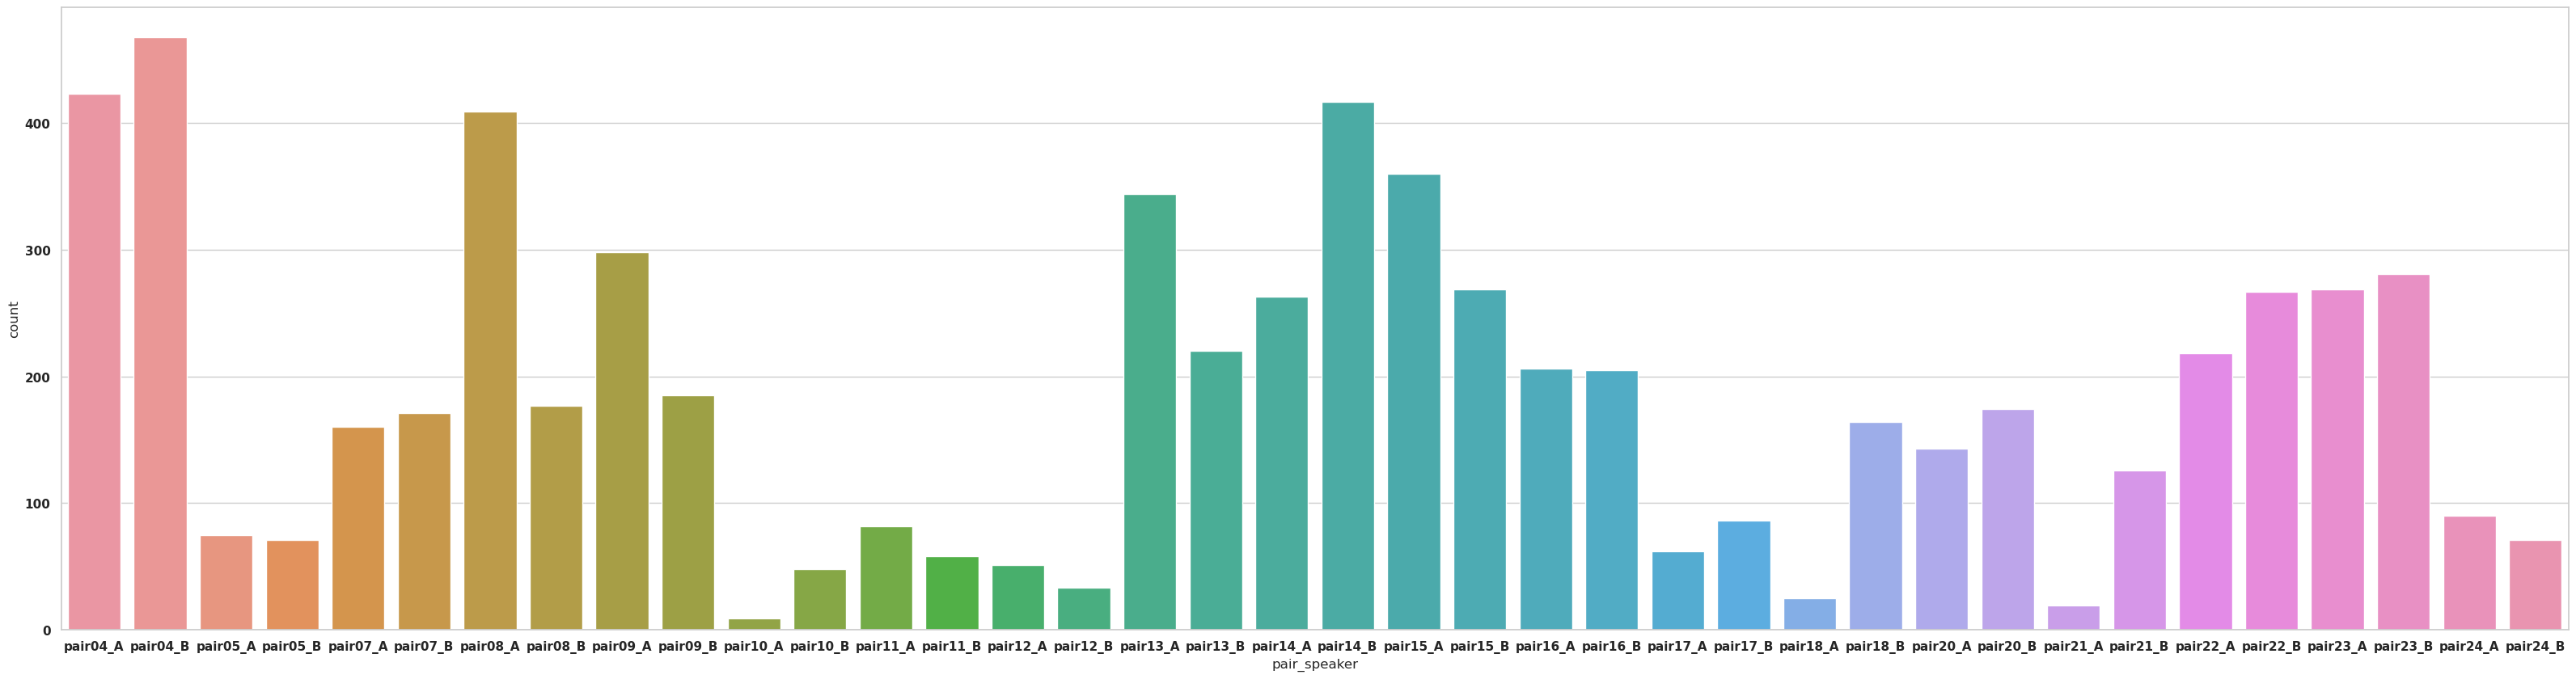

In [20]:
# count the number of iconic gestures for each pair_speaker, then plot the distribution of the counts
gestures_info['pair_speaker'] = gestures_info['pair'] +'_'+ gestures_info['speaker']
numb_gestures_per_speaker = gestures_info.groupby('pair_speaker').count().reset_index().rename(columns={'pair': 'count'})[['pair_speaker', 'count']]
# size of the plot
plt.figure(figsize=(40, 10))
# make the fond bold and size 30
plt.rc('font', size=30, weight='bold')

sns.barplot(x='pair_speaker', y='count', data=numb_gestures_per_speaker)

In [21]:
iconic_gestures_info

pair  turn round    type is_gesture  from_ts    to_ts referent  \
1     pair04     0     1  iconic    gesture     4.09     4.50     main   
5     pair04     2     1  iconic    gesture     8.46     8.94      09C   
8     pair04     4     1  iconic    gesture    11.78    12.20      09C   
9     pair04     4     1  iconic    gesture    11.97    12.39   15A-WF   
10    pair04     4     1  iconic    gesture    12.29    12.73      09C   
...      ...   ...   ...     ...        ...      ...      ...      ...   
6992  pair24   458     4  iconic    gesture  1300.69  1301.63      16C   
6993  pair24   459     4  iconic    gesture  1300.69  1301.63      16C   
6994  pair24   470     4  iconic    gesture  1321.06  1321.42  general   
6995  pair24   470     4  iconic    gesture  1322.46  1322.70      12B   
6996  pair24   470     4  iconic    gesture  1323.18  1324.02      12C   

                 comment  duration    hand     WF target_fribble role speaker  \
1                             0.41  [R, L]  False             09    B       B   
5                             0.48     [L]  False             09    B       B   
8                             0.42     [L]  False             09    B       B   
9     superimposed beats      0.42     [L]   True             09    B       B   
10      Post-stroke hold      0.44     [L]  False             09    B       B   
...                  ...       ...     ...    ...            ...  ...     ...   
6992                          0.95  [R, L]  False             16    B       A   
6993                          0.95  [R, L]  False             16    B       B   
6994                          0.36     [L]  False             12    B       B   
6995                          0.24  [R, L]  False             12    B       B   
6996                          0.84     [L]  False             12    B       B   

     processed_referent pair_speaker  
1               09_main     pair04_B  
5                   09C     pair04_B  
8                   09C     pair04_B  
9                   15A     pair04_B  
10                  09C     pair04_B  
...                 ...          ...  
6992                16C     pair24_A  
6993                16C     pair24_B  
6994         12_general     pair24_B  
6995                12B     pair24_B  
6996                12C     pair24_B  

[5958 rows x 17 columns]

In [22]:
class ExpTurns:
    def __init__(self):
        self.exp_turns = []

    def add(self, exp, turn, speaker, pair, from_ts, to_ts, round, role, target_fribble):
        for item in self.exp_turns:
            if item['exp'] == exp:
                item['turns'].append(turn)
                item['speakers'].append(speaker)
                item['pair'].append(pair)
                item['from_ts'].append(from_ts)
                item['to_ts'].append(to_ts)
                item['round'].append(round)
                item['role'].append(role)
                item['target_fribble'].append(target_fribble)
                return
        self.exp_turns.append({'exp': exp, 'turns': [turn], 'speakers': [speaker], 'pair': [pair], 'from_ts': [from_ts], 'to_ts': [to_ts], 'round': [round], 'role': [role], 'target_fribble': [target_fribble]})

# Usage
gestural_expressions = ExpTurns()
alignment_patterns = defaultdict(list)
pairs = iconic_gestures_info['pair'].unique()
trials = iconic_gestures_info['target_fribble'].unique()
for pair in pairs:
    for trial in trials:
      pairs_trails_iconic_gestures = iconic_gestures_info[(iconic_gestures_info['pair'] == pair) & (iconic_gestures_info['target_fribble'] == trial)]
      for index, row in pairs_trails_iconic_gestures.iterrows():
        gestural_expressions.add(row['processed_referent']+'_'+row['pair'], row['turn'], row['speaker'], row['pair'], row['from_ts'], row['to_ts'], row['round'], row['role'], row['target_fribble'])

<AxesSubplot: xlabel='repetition', ylabel='count'>

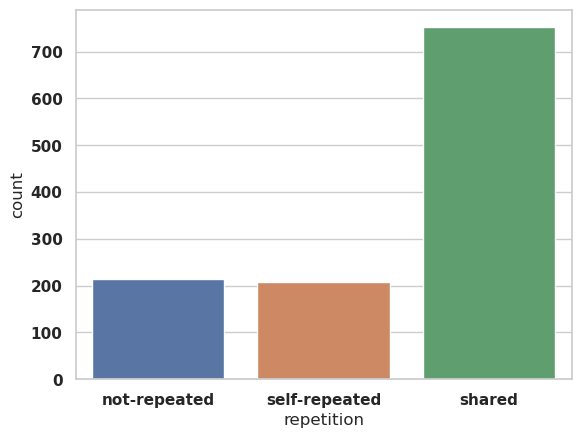

In [23]:
# convert the list of exp_turns in gestural_expressions to a pandas DataFrame
exp_turns_df = pd.DataFrame(gestural_expressions.exp_turns)
# label each row as shared, self-repeated, or not repeated based on the number of speakers in the row
exp_turns_df['repetition'] = exp_turns_df.apply(lambda row: 'shared' if len(set(row['speakers'])) == 2 else 'self-repeated' if ((len(set(row['speakers'])) == 1) & (len(row['speakers']) > 1)) else 'not-repeated', axis=1)
# plot the distribution of the repetition types
sns.barplot(x='repetition', y='count', data=exp_turns_df.groupby('repetition').count().reset_index().rename(columns={'exp': 'count'}))


In [24]:
# calculate the establishment round
def get_establishment_round(row):
   # establishment round is the round where the speaker is different than the first speaker in the row
   for i in range(len(row['speakers'])):
       if row['speakers'][i] != row['speakers'][0]:
          return row['round'][i]
   return -1
shared_exp_turns_df = exp_turns_df[exp_turns_df['repetition'] == 'shared']
shared_exp_turns_df['establishment_round'] = shared_exp_turns_df.apply(lambda row: get_establishment_round(row), axis=1)
shared_exp_turns_df['target_fribble'] = shared_exp_turns_df.apply(lambda row: int(row['target_fribble'][0]), axis=1)
shared_exp_turns_df['pair'] = shared_exp_turns_df.apply(lambda row: row['pair'][0], axis=1)

In [25]:
shared_exp_turns_df

exp  \
0        09_main_pair04   
1            09C_pair04   
2            15A_pair04   
3            09D_pair04   
4            09A_pair04   
...                 ...   
1166         05E_pair24   
1167         04B_pair24   
1171  12_general_pair24   
1172         12B_pair24   
1173         12C_pair24   

                                                                                                   turns  \
0                                                                          [0, 15, 15, 16, 16, 293, 409]   
1                                           [2, 4, 4, 5, 5, 20, 20, 20, 21, 21, 183, 183, 295, 295, 295]   
2                                     [4, 5, 59, 59, 59, 60, 60, 260, 311, 312, 378, 505, 505, 507, 589]   
3                                          [6, 8, 9, 25, 25, 26, 184, 184, 294, 409, 477, 477, 564, 565]   
4     [7, 7, 22, 23, 23, 185, 185, 185, 185, 186, 186, 187, 293, 297, 297, 298, 298, 298, 300, 301, 478]   
...                                                                                                  ...   
1166                                        [329, 331, 331, 331, 332, 333, 333, 333, 334, 335, 335, 335]   
1167                                                                                          [385, 386]   
1171                                                                                          [207, 470]   
1172                                                                                          [207, 470]   
1173                                                                                          [207, 470]   

                                                             speakers    pair  \
0                                               [B, A, A, B, B, B, A]  pair04   
1                       [B, B, B, A, A, B, B, B, A, A, A, A, B, B, B]  pair04   
2                       [B, A, B, B, B, A, A, A, B, A, A, B, B, A, A]  pair04   
3                          [B, B, B, B, B, A, A, A, B, A, B, B, A, B]  pair04   
4     [B, B, A, B, B, A, A, A, A, B, B, A, B, A, A, B, B, B, B, A, B]  pair04   
...                                                               ...     ...   
1166                             [A, B, B, B, A, A, A, A, A, B, B, B]  pair24   
1167                                                           [B, A]  pair24   
1171                                                           [A, B]  pair24   
1172                                                           [A, B]  pair24   
1173                                                           [A, B]  pair24   

                                                                                                                                                                                   from_ts  \
0                                                                                                                                     [4.093, 40.616, 42.0, 40.616, 42.0, 780.69, 1090.15]   
1                                                                   [8.459, 11.781, 12.29, 11.781, 12.29, 50.395, 52.49, 53.75, 52.49, 53.75, 500.988, 502.563, 787.893, 788.778, 789.654]   
2                                                 [11.97, 11.97, 153.145, 153.819, 154.531, 153.819, 154.531, 683.132, 819.849, 819.849, 1001.239, 1358.681, 1359.097, 1359.097, 1586.982]   
3                                                              [15.0, 20.255, 21.887, 58.563, 59.745, 59.745, 505.662, 506.689, 783.991, 1094.026, 1278.831, 1280.893, 1515.654, 1515.654]   
4     [16.726, 18.79, 55.254, 55.254, 55.89, 509.168, 513.25, 514.238, 515.202, 514.238, 515.202, 516.912, 781.531, 794.185, 794.38, 794.185, 794.38, 795.044, 798.026, 798.026, 1284.345]   
...                                                                                                                                                                                    ...   
1166                                                                          [952.345, 957.068

<AxesSubplot: xlabel='establishment_round', ylabel='count'>

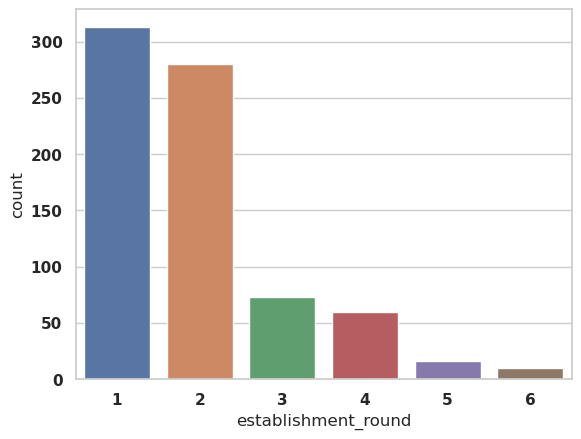

In [26]:
# plot the distribution of the establishment round
sns.barplot(x='establishment_round', y='count', data=shared_exp_turns_df.groupby('establishment_round').count().reset_index().rename(columns={'exp': 'count'}))

In [27]:
next(iter(shared_exp_turns_df.groupby(['pair', 'target_fribble'])))

(('pair04', 1),
                   exp  \
 90         01A_pair04   
 91         01B_pair04   
 92  01_general_pair04   
 93         01C_pair04   
 
                                                       turns  \
 90       [155, 155, 155, 278, 278, 325, 326, 386, 500, 501]   
 91                 [156, 277, 324, 324, 386, 500, 500, 500]   
 92                                     [156, 386, 570, 570]   
 93  [156, 158, 159, 277, 277, 277, 325, 386, 386, 570, 570]   
 
                              speakers    pair  \
 90     [B, B, B, A, A, B, A, A, B, A]  pair04   
 91           [B, A, B, B, A, B, B, B]  pair04   
 92                       [B, A, A, A]  pair04   
 93  [B, A, A, A, A, A, B, A, A, A, A]  pair04   
 
                                                                                                    from_ts  \
 90            [435.982, 436.941, 438.097, 739.18, 739.634, 857.433, 857.433, 1027.903, 1344.247, 1344.247]   
 91                            [439.796, 732.947, 851.00

In [28]:
# count the number of shared expressions for each pair and target fribble
num_gestural_exp = shared_exp_turns_df[['exp', 'pair', 'target_fribble']].groupby(['pair', 'target_fribble']).count().reset_index().rename(columns={'exp': 'count'})
# plot the distribution of the number of shared expressions
# count the number of target_fribble for each pair
num_target_fribbles_per_pair = num_gestural_exp[['pair', 'target_fribble']].groupby('pair').count().reset_index().rename(columns={'target_fribble': 'count'})
# devide the count of shared expressions by 16 (the total number of target fribbles) to get the percentage of shared expressions
num_target_fribbles_per_pair['count'] = num_target_fribbles_per_pair.apply(lambda row: row['count']/16 * 100, axis=1)

In [29]:
# add the average number iconic gestures (given speakers a and b) for each pair to the num_target_fribbles_per_pair DataFrame
for index, row in num_target_fribbles_per_pair.iterrows():
   # first calculate the average number of gestures for each speaker, in gestures_info
   average_num_gestures_per_speaker = iconic_gestures_info[iconic_gestures_info['pair'] == row['pair']][['speaker', 'processed_referent']].groupby('speaker').count().reset_index().rename(columns={'processed_referent': 'count'})
   average_num_gestures = average_num_gestures_per_speaker['count'].mean()
   num_target_fribbles_per_pair.loc[index, 'avg_num_gestures'] = average_num_gestures

In [30]:
# calculate the correlation between the count of target fribbles and the avg_num_gestures
num_target_fribbles_per_pair['count'].corr(num_target_fribbles_per_pair['avg_num_gestures'])

0.8193520919762491

In [31]:
num_target_fribbles_per_pair

pair   count  avg_num_gestures
0   pair04  100.00             390.0
1   pair05   56.25              60.0
2   pair07   93.75             143.0
3   pair08  100.00             248.5
4   pair09  100.00             217.5
5   pair10   18.75              25.5
6   pair11   56.25              50.0
7   pair12   31.25              29.0
8   pair13   93.75             233.0
9   pair14  100.00             267.0
10  pair15  100.00             237.0
11  pair16   93.75             152.5
12  pair17   68.75              65.5
13  pair18   75.00              82.0
14  pair20  100.00             139.5
15  pair21   37.50              65.0
16  pair22   93.75             209.0
17  pair23  100.00             274.5
18  pair24   62.50              90.5

In [33]:
# create a count dictionary for processed_referent
from collections import Counter
referents = iconic_gestures_info['processed_referent'].tolist()
# created a counter for referents, for each item without the sublist
referents_counter = Counter([item for item in referents])

In [36]:
all_shared_iconic_gestures = shared_exp_turns_df.explode(['turns', 'from_ts', 'to_ts', 'round', 'speakers', 'role'])

In [38]:
from utils.compute_shared_exp_time_windows import get_turn_from_to_ts
time_based_exp_info['to_ts'] = time_based_exp_info.apply(lambda row: get_turn_from_to_ts(row, turns_info, 'to_ts'), axis=1) # type: ignore
time_based_exp_info['from_ts'] = time_based_exp_info.apply(lambda row: get_turn_from_to_ts(row, turns_info, 'from_ts'), axis=1) # type: ignore
assert_match_betwee_shared_exp_and_actual_utterances(turns_info, shared_constructions_info)
# iconic_gestures_info = gestures_info[gestures_info['type'] =='iconic']
# iconic_gestures_info.describe()
from utils.select_baseline_non_shared_expressions import annonate_time_based_exps
time_based_exp_info, content_time_based_exp_info = annonate_time_based_exps(time_based_exp_info, pos_func_words, function_words, interaction_words, frequent_words)
from utils.select_baseline_non_shared_expressions import get_non_shared_expressions
# Establish a strong baseline for non-shared expressions
non_shared_constructions_info = get_non_shared_expressions(time_based_exp_info, turns_info, pos_func_words, function_words, interaction_words, frequent_words, get_turn_from_to_ts, pairs_without_audio_recordings)

# Algorithm to sample non-shared expressions
1- Get the length distribution of shared expressions

2- Sample five times the number of non-shared expressions from the geometric distribution

3- Filter out non-shared expressions that contain only function words

4- For each length in the shared expressions, sample the same number of non-shared expressions from the non-shared expressions of the same length using the following criteria

      a- If the length of the shared expression is < 3, sample a non-shared expression of length < 3 with the same distribution of POS tags
   
      b- If the length of the shared expression is >= 3, sample a non-shared expression of length >= 3 with the same distribution of POS tags

In [ ]:
# convert first_round column to int
content_time_based_exp_info['first_round'] = content_time_based_exp_info['first_round'].astype(int)
content_time_based_exp_info['estab_round'] = content_time_based_exp_info['estab_round'].astype(int)
# select content_time_based_exp_info where round is the same as the first round
first_round_content_time_based_exp_info = content_time_based_exp_info[content_time_based_exp_info['round'] == content_time_based_exp_info['first_round']]
estab_round_content_time_based_exp_info = content_time_based_exp_info[content_time_based_exp_info['round'] == content_time_based_exp_info['estab_round']]

duration:  0.0
length:  1
duration:  1.0
length:  1
duration:  2.0
length:  1
duration:  3.0
length:  1
duration:  4.0
length:  1
duration:  5.0
length:  1
duration:  6.0
length:  1
duration:  7.0
length:  1
duration:  8.0
length:  1
duration:  9.0
length:  1
duration:  10.0
length:  1
duration:  11.0
length:  1
duration:  12.0
length:  1
duration:  13.0
length:  1
duration:  14.0
length:  1
duration:  15.0
length:  1
duration:  16.0
length:  1
duration:  17.0
length:  1
duration:  18.0
length:  1
duration:  19.0
length:  1
duration:  20.0
length:  1
duration:  21.0
length:  1
duration:  22.0
length:  1
duration:  23.0
length:  1
duration:  24.0
length:  1
duration:  25.0
length:  1
duration:  26.0
length:  1
duration:  29.0
length:  1
duration:  0.0
length:  2
duration:  1.0
length:  2
num_exps_with_length is 0 and tag is NOUN: 
len(non_shared_constructions_info_with_length_and_tag):  10
num_exps_with_length is 0 and tag is DET: 
len(non_shared_constructions_info_with_length_and_tag):

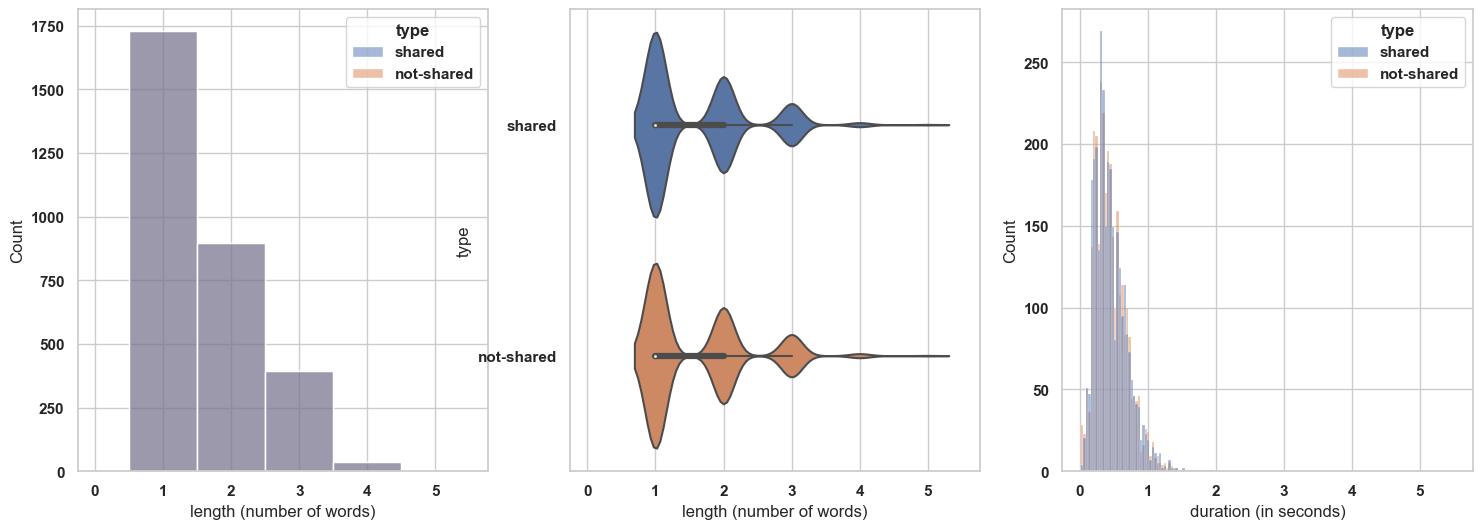

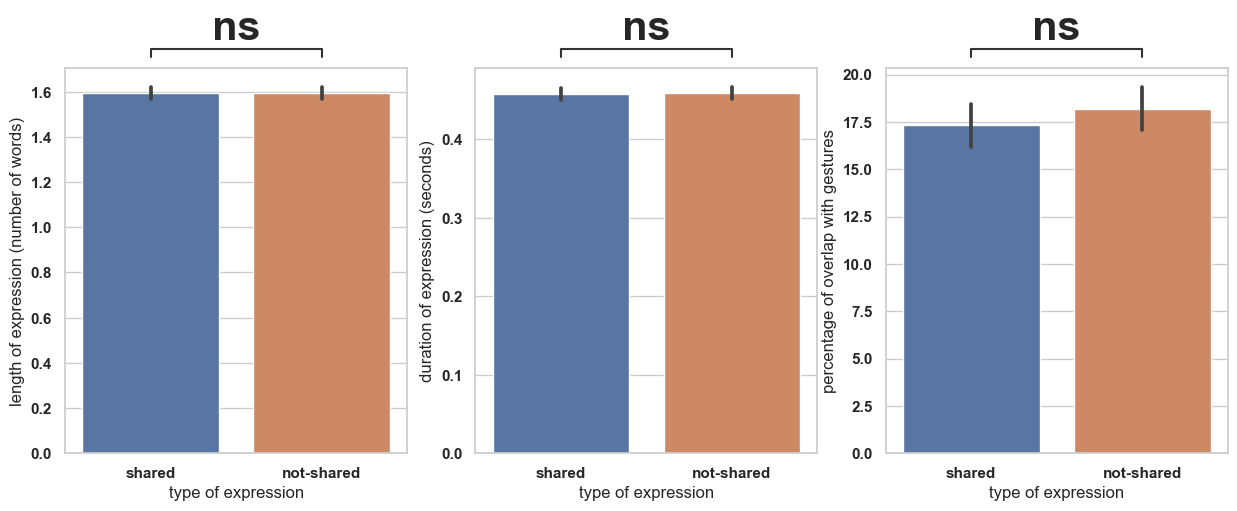

In [ ]:
from utils.select_baseline_non_shared_expressions import plot_dists_of_shared_non_shared_lengths_duration_overlap
estab_selected_shared_non_shared_exp = plot_dists_of_shared_non_shared_lengths_duration_overlap(estab_round_content_time_based_exp_info, non_shared_constructions_info, iconic_gestures_info, select_balanced=True, round=0, remove_punct_intj_sym_space=False)

duration:  0.0
length:  1
total_num_exps_given_tags == len(content_time_based_exp_info_length)
num_exps_with_length is 1 and tag is ADJ: 
len(non_shared_constructions_info_with_length_and_tag):  6
total_num_exps_given_tags == len(content_time_based_exp_info_length)
num_exps_with_length is 5 and tag is NOUN: 
len(non_shared_constructions_info_with_length_and_tag):  3
total_num_exps_given_tags == len(content_time_based_exp_info_length)
num_exps_with_length is 1 and tag is VERB: 
len(non_shared_constructions_info_with_length_and_tag):  4
duration:  1.0
length:  1
total_num_exps_given_tags == len(content_time_based_exp_info_length)
num_exps_with_length is 5 and tag is ADJ: 
len(non_shared_constructions_info_with_length_and_tag):  7
total_num_exps_given_tags == len(content_time_based_exp_info_length)
num_exps_with_length is 5 and tag is ADV: 
len(non_shared_constructions_info_with_length_and_tag):  4
total_num_exps_given_tags == len(content_time_based_exp_info_length)
num_exps_with_length i

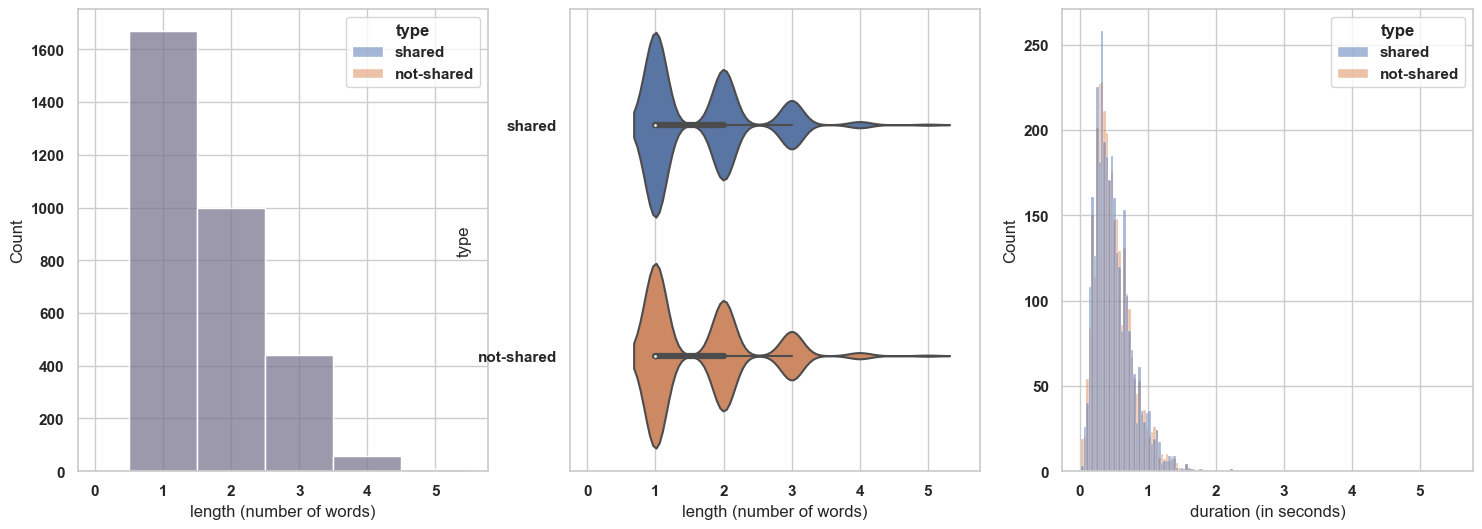

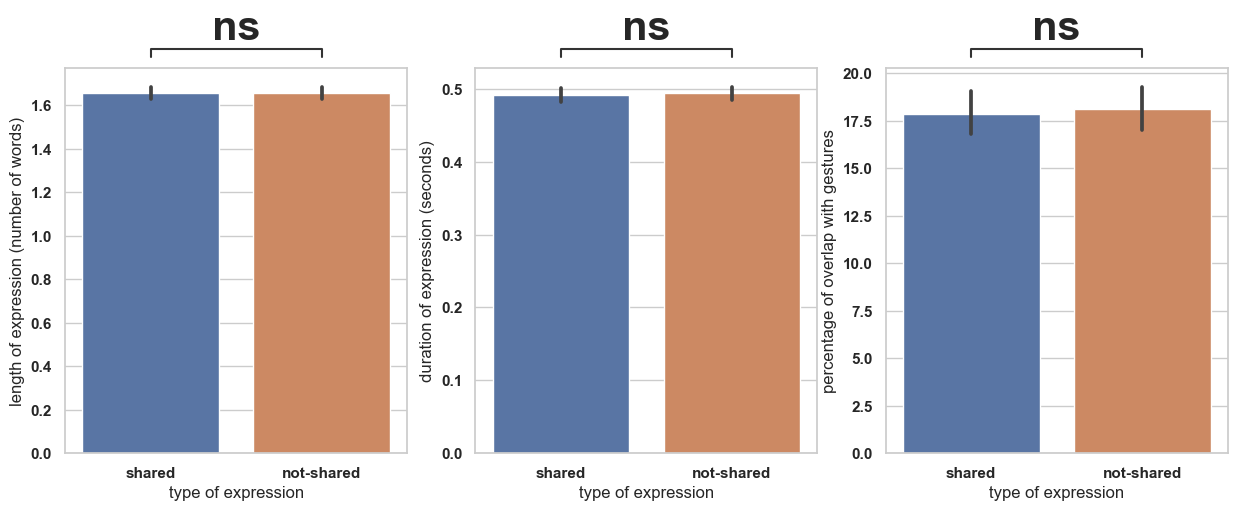

In [ ]:
from utils.select_baseline_non_shared_expressions import plot_dists_of_shared_non_shared_lengths_duration_overlap
first_selected_shared_non_shared_exp = plot_dists_of_shared_non_shared_lengths_duration_overlap(first_round_content_time_based_exp_info, non_shared_constructions_info, iconic_gestures_info, select_balanced=True, round=0, remove_punct_intj_sym_space=False)

duration:  0.0
length:  1
total_num_exps_given_tags == len(content_time_based_exp_info_length)
num_exps_with_length is 1 and tag is ADJ: 
len(non_shared_constructions_info_with_length_and_tag):  6
total_num_exps_given_tags == len(content_time_based_exp_info_length)
num_exps_with_length is 5 and tag is NOUN: 
len(non_shared_constructions_info_with_length_and_tag):  3
total_num_exps_given_tags == len(content_time_based_exp_info_length)
num_exps_with_length is 1 and tag is VERB: 
len(non_shared_constructions_info_with_length_and_tag):  4
duration:  1.0
length:  1
total_num_exps_given_tags == len(content_time_based_exp_info_length)
num_exps_with_length is 5 and tag is ADJ: 
len(non_shared_constructions_info_with_length_and_tag):  7
total_num_exps_given_tags == len(content_time_based_exp_info_length)
num_exps_with_length is 5 and tag is ADV: 
len(non_shared_constructions_info_with_length_and_tag):  4
total_num_exps_given_tags == len(content_time_based_exp_info_length)
num_exps_with_length i

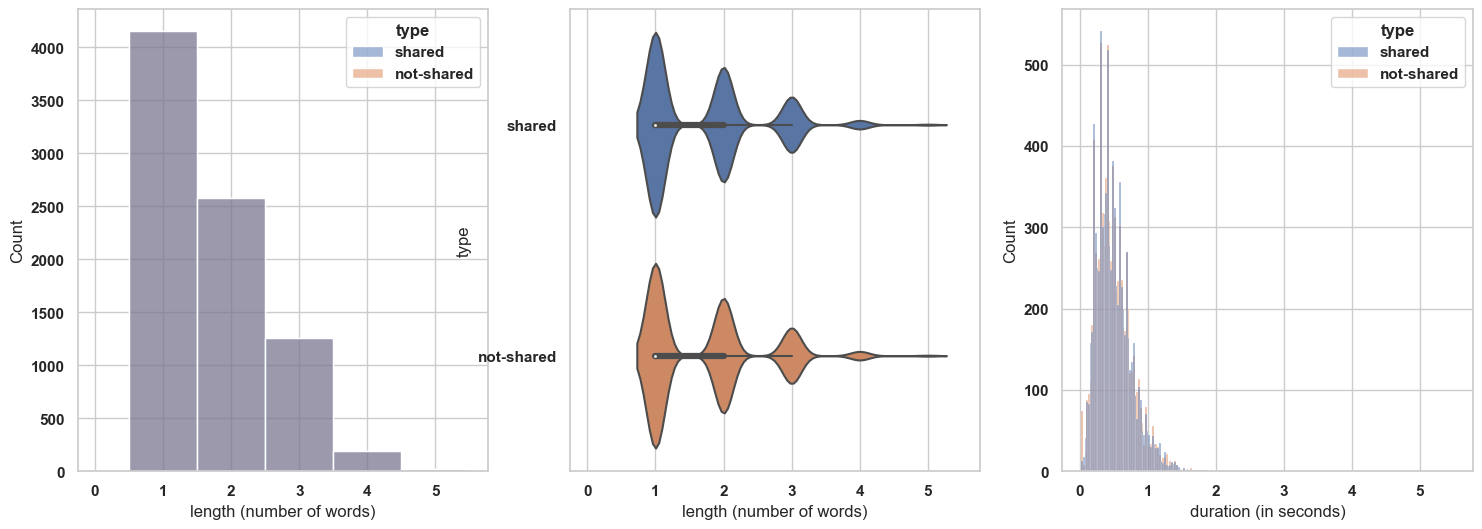

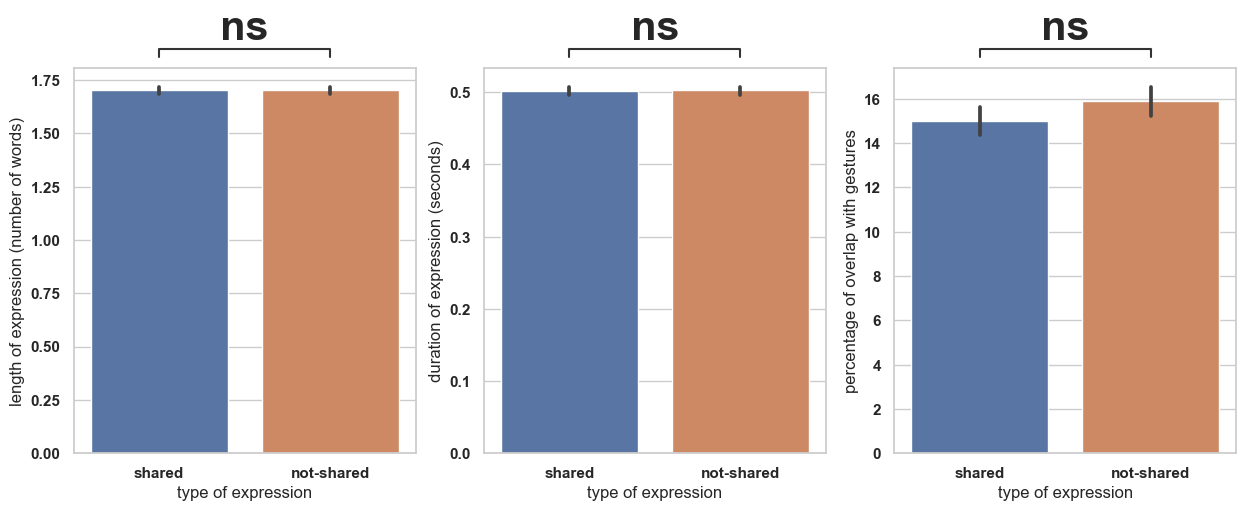

In [ ]:
from utils.select_baseline_non_shared_expressions import plot_dists_of_shared_non_shared_lengths_duration_overlap
selected_shared_non_shared_exp = plot_dists_of_shared_non_shared_lengths_duration_overlap(content_time_based_exp_info, non_shared_constructions_info, iconic_gestures_info, select_balanced=True, round=0, remove_punct_intj_sym_space=False)

In [ ]:
len(selected_shared_non_shared_exp[selected_shared_non_shared_exp['type'] == 'shared'])

7110

In [ ]:
len(selected_shared_non_shared_exp[selected_shared_non_shared_exp['type'] == 'not-shared'])

7110

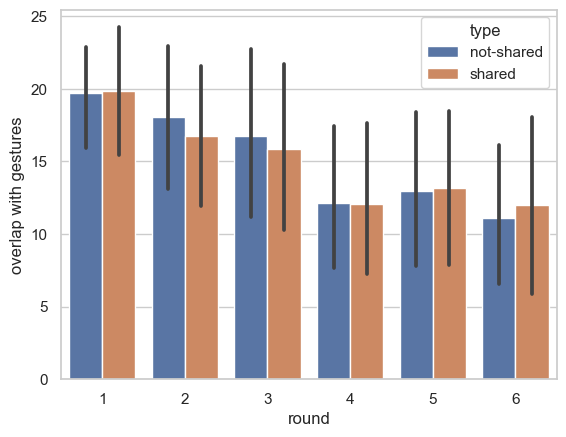

In [ ]:
# group non_shared_constructions_info by pair, turn, round, and type, and compute the mean of the duration
from statannotations.Annotator import Annotator

grouped_selected_shared_non_shared_exp = selected_shared_non_shared_exp.groupby(['pair', 'round', 'type'])['overlap with gestures'].mean().reset_index()
# grouped_selected_shared_non_shared_exp['round'] = grouped_selected_shared_non_shared_exp['round'].apply(lambda x: int(x))
# bar plot of the overlap with gestures, hue is type of expressions, x axis is round, y axis is the mean of the overlap with gestures
ax = sns.barplot(x='round', y='overlap with gestures', hue='type', data=grouped_selected_shared_non_shared_exp)

# x = 'type'
# y = 'overlap with gestures'
# pairs = [(('shared', 1), ('not-shared', 1))]
# order = np.unique(grouped_selected_shared_non_shared_exp['type']).tolist()
# hue = 'type'
# annotator = Annotator(ax, pairs, data=grouped_selected_shared_non_shared_exp, x=x, y=y, order=order, verbose=False, log=False, )
# annotator.configure(test='t-test_welch', text_format='star', loc='outside')
# annotator.apply_and_annotate()

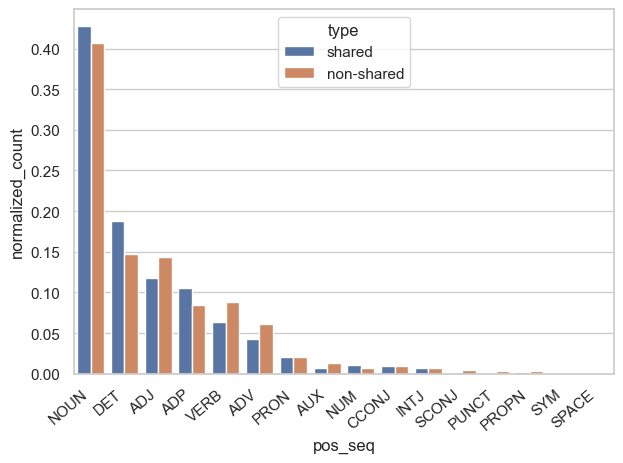

In [ ]:
selected_shared_non_shared_exp_round_1 = selected_shared_non_shared_exp[selected_shared_non_shared_exp['round'] == 1]
non_shared_exps_pos_seqs = selected_shared_non_shared_exp_round_1[selected_shared_non_shared_exp_round_1['type'] == 'not-shared']['pos_seq'].to_list()
shared_exps_pos_seqs = selected_shared_non_shared_exp_round_1[selected_shared_non_shared_exp_round_1['type'] == 'shared']['pos_seq'].to_list()
# convert the list of strings to one string
non_shared_exps_pos_seqs = ' '.join(non_shared_exps_pos_seqs)
shared_exps_pos_seqs = ' '.join(shared_exps_pos_seqs)
# construct a dictionary to count occurrences of each pos tag
non_shared_exps_pos_seqs_dict = Counter(non_shared_exps_pos_seqs.split())
shared_exps_pos_seqs_dict = Counter(shared_exps_pos_seqs.split())
non_shared_exps_pos_seqs_df = pd.DataFrame.from_dict([non_shared_exps_pos_seqs_dict]).T
non_shared_exps_pos_seqs_df['type'] = 'non-shared'
# change the index to values from 0 to len(index)
non_shared_exps_pos_seqs_df = non_shared_exps_pos_seqs_df.reset_index()
# rename the index column to pos_seq, and the 0 column to count
non_shared_exps_pos_seqs_df = non_shared_exps_pos_seqs_df.rename(columns={'index': 'pos_seq', 0: 'count'})
non_shared_exps_pos_seqs_df['normalized_count'] = non_shared_exps_pos_seqs_df['count'] / non_shared_exps_pos_seqs_df['count'].sum()

# normalize the count 
shared_exps_pos_seqs_df = pd.DataFrame.from_dict([shared_exps_pos_seqs_dict]).T
shared_exps_pos_seqs_df['type'] = 'shared'
# change the index to values from 0 to len(index)
shared_exps_pos_seqs_df = shared_exps_pos_seqs_df.reset_index()
# rename the index column to pos_seq, and the 0 column to count
shared_exps_pos_seqs_df = shared_exps_pos_seqs_df.rename(columns={'index': 'pos_seq', 0: 'count'})
shared_exps_pos_seqs_df['normalized_count'] = shared_exps_pos_seqs_df['count'] / shared_exps_pos_seqs_df['count'].sum()
# combine them both
pos_seqs_df = pd.concat([non_shared_exps_pos_seqs_df, shared_exps_pos_seqs_df], axis=0).sort_values(by=['count'], ascending=False)
# normalize the count per type
# plot the results using seaborn
sns.set_theme(style="whitegrid")
ax = sns.barplot(x='pos_seq', y="normalized_count", hue="type", data=pos_seqs_df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()